In [1]:
# Install necessary libraries
# !pip install gym
# !pip install stable-baselines3
#!pip install mplcursors

In [2]:
import numpy as np
import pandas as pd
from IPython.display import display
import requests
import json
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import mplcursors
import warnings
import os

# Data Processing

In [4]:
#CYS & Panko

# Import API
api_key = 'e1d6c125a1a3cb5682e428d0c7da0621e6220336922e4103fcbdbd19af8e8bf9'

def get_eth_daily_price(api_key):
    url = 'https://min-api.cryptocompare.com/data/v2/histoday'
    parameters = {
        'fsym': 'ETH',  
        'tsym': 'USD',
        'limit': '2000',
        'api_key': api_key
    }

    response = requests.get(url, params=parameters)
    data = response.json()

    df = pd.DataFrame(columns=['Time', 'Open', 'High', 'Low', 'Close', 'Vol'])

    if response.status_code == 200 and 'Data' in data and 'Data' in data['Data']:

        daily_prices = data['Data']['Data']
        rows = []  
        for price in daily_prices:

            row = {
                'Time': pd.to_datetime(price['time'], unit='s'),
                'Open': price['open'],
                'High': price['high'],
                'Low': price['low'],
                'Close': price['close'],
                'Vol': price['volumefrom']
            }
            rows.append(row)
        df = pd.concat([df, pd.DataFrame(rows)], ignore_index=True)
    else:
        print("无法获取数据")

    return df

eth_data = get_eth_daily_price(api_key)

print(eth_data)

eth_data['Change'] = (eth_data['Close'] - eth_data['Close'].shift(1)) / eth_data['Close'].shift(1)

print(eth_data)

eth_data['Time'] = (eth_data['Time'] - pd.Timestamp("1970-01-01")).dt.days

def convert_vol(x):
    if isinstance(x, str):
        if 'K' in x:
            return float(x.replace('K', '')) * 1000
        elif 'M' in x:
            return float(x.replace('M', '')) * 1000000
    try:
        return float(x)
    except:
        return None

def convert_percentage(x):
    if isinstance(x, str) and '%' in x:
        return float(x.replace('%', '')) / 100
    try:
        return float(x)
    except:
        return None

eth_data['Vol'] = eth_data['Vol'].apply(convert_vol)
eth_data['Change'] = eth_data['Change'].apply(convert_percentage)

eth_data = eth_data.sort_values(by='Time').reset_index(drop=True)

display(eth_data.head())


           Time     Open     High      Low    Close         Vol
0    2019-01-31   108.52   108.79   105.77   106.46  2030539.26
1    2019-02-01   106.46   107.62   105.55   106.72  1698659.24
2    2019-02-02   106.72   110.80   107.93   110.56  1615356.38
3    2019-02-03   110.56   109.11   106.56   107.04  1882567.19
4    2019-02-04   107.04   107.54   105.92   106.61  2060237.91
...         ...      ...      ...      ...      ...         ...
1996 2024-07-19  3425.94  3542.18  3376.46  3506.00   362043.38
1997 2024-07-20  3506.00  3541.04  3482.21  3518.85   155617.03
1998 2024-07-21  3518.85  3547.99  3413.60  3536.46   237146.07
1999 2024-07-22  3536.46  3563.26  3424.39  3441.05   293172.34
2000 2024-07-23  3441.05  3490.89  3425.93  3461.05   101418.10

[2001 rows x 6 columns]
           Time     Open     High      Low    Close         Vol    Change
0    2019-01-31   108.52   108.79   105.77   106.46  2030539.26       NaN
1    2019-02-01   106.46   107.62   105.55   106.72  169865

C:\Users\kybun\AppData\Local\Temp\ipykernel_6184\654702164.py:35: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  df = pd.concat([df, pd.DataFrame(rows)], ignore_index=True)


,Time,Open,High,Low,Close,Vol,Change
0,17927,108.52,108.79,105.77,106.46,2030539.26,NaN
1,17928,106.46,107.62,105.55,106.72,1698659.24,0.002442
2,17929,106.72,110.80,107.93,110.56,1615356.38,0.035982
3,17930,110.56,109.11,106.56,107.04,1882567.19,-0.031838
4,17931,107.04,107.54,105.92,106.61,2060237.91,-0.004017


## Create Derivative Indicator

In [5]:
import talib

eth_data['EMA_7'] = talib.EMA(eth_data['Close'].values, timeperiod=7)
eth_data['EMA_25'] = talib.EMA(eth_data['Close'].values, timeperiod=25)
eth_data['EMA_99'] = talib.EMA(eth_data['Close'].values, timeperiod=99)

eth_data['upper_band'], eth_data['middle_band'], eth_data['lower_band'] = talib.BBANDS(eth_data['Close'].values,
                                                                                        timeperiod=21,
                                                                                        nbdevup=2,
                                                                                        nbdevdn=2,
                                                                                        matype=0)

eth_data['RSI'] = talib.RSI(eth_data['Close'].values, timeperiod=14)

eth_data['slowk'], eth_data['slowd'] = talib.STOCH(eth_data['High'].values,
                                                    eth_data['Low'].values,
                                                    eth_data['Close'].values,
                                                    fastk_period=5,
                                                    slowk_period=3,
                                                    slowk_matype=0,
                                                    slowd_period=3,
                                                    slowd_matype=0)

eth_data['MACD'], eth_data['MACD_signal'], eth_data['MACD_hist'] = talib.MACD(eth_data['Close'].values,
                                                                               fastperiod=12,
                                                                               slowperiod=26,
                                                                               signalperiod=9)

eth_data['CCI'] = talib.CCI(eth_data['High'].values,
                            eth_data['Low'].values,
                            eth_data['Close'].values,
                            timeperiod=14)

eth_data['ATR'] = talib.ATR(eth_data['High'].values,
                            eth_data['Low'].values,
                            eth_data['Close'].values,
                            timeperiod=14)

eth_data['ROC'] = talib.ROC(eth_data['Close'].values, timeperiod=10)

In [6]:
import pandas as pd

def calculate_ultimate_oscillator(eth_data):

    eth_data = eth_data.sort_values(by='Time').reset_index(drop=True)

    eth_data['BP'] = eth_data['Close'] - eth_data[['Low', 'Close']].shift(1).min(axis=1)
    eth_data['TR'] = eth_data[['High', 'Close']].shift(1).max(axis=1) - eth_data[['Low', 'Close']].shift(1).min(axis=1)

    UO = pd.Series(0, index=eth_data.index)

    periods = [7, 14, 28]
    weights = [4, 2, 1]

    for period, weight in zip(periods, weights):
        ABP = eth_data['BP'].rolling(window=period).sum()
        ATR = eth_data['TR'].rolling(window=period).sum()

        ratio = ABP / ATR
        ratio[ATR == 0] = 0 
        UO += weight * ratio

    eth_data['UO'] = UO / sum(weights)

    return eth_data

eth_data = calculate_ultimate_oscillator(eth_data)

display(eth_data)


,Time,Open,High,Low,Close,Vol,Change,EMA_7,EMA_25,EMA_99,...,slowd,MACD,MACD_signal,MACD_hist,CCI,ATR,ROC,BP,TR,UO
0,17927,108.52,108.79,105.77,106.46,2030539.26,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,17928,106.46,107.62,105.55,106.72,1698659.24,0.002442,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.95,3.02,NaN
2,17929,106.72,110.80,107.93,110.56,1615356.38,0.035982,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.01,2.07,NaN
3,17930,110.56,109.11,106.56,107.04,1882567.19,-0.031838,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,-0.89,2.87,NaN
4,17931,107.04,107.54,105.92,106.61,2060237.91,-0.004017,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.05,2.55,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1996,19923,3425.94,3542.18,3376.46,3506.00,362043.38,0.023369,3382.651553,3315.627174,3326.420835,...,79.206979,9.846063,-45.347636,55.193700,108.995520,146.619123,14.334538,138.24,122.05,0.901502
1997,19924,3506.00,3541.04,3482.21,3518.85,155617.03,0.003665,3416.701165,3331.259699,3330.269419,...,78.829870,24.402453,-31.397618,55.800072,103.534584,140.348471,13.495181,142.39,165.72,0.878840
1998,19925,3518.85,3547.99,3413.60,3536.46,237146.07,0.005004,3446.640874,3347.044338,3334.393230,...,83.292270,36.933728,-17.731349,54.665077,84.010213,139.922866,14.098126,54.25,58.83,0.874523
1999,19926,3536.46,3563.26,3424.39,3441.05,293172.34,-0.026979,3445.243155,3354.275543,3336.526366,...,82.101455,38.719727,-6.441134,45.160861,66.296706,139.847662,9.775667,27.45,134.39,0.691904


In [7]:
eth_data.dropna(inplace=True)

In [8]:
invalid_prices = eth_data[eth_data['Close'] <= 0]

print("current_price abnormal data：")
print(invalid_prices)

current_price abnormal data：
Empty DataFrame
Columns: [Time, Open, High, Low, Close, Vol, Change, EMA_7, EMA_25, EMA_99, upper_band, middle_band, lower_band, RSI, slowk, slowd, MACD, MACD_signal, MACD_hist, CCI, ATR, ROC, BP, TR, UO]
Index: []

[0 rows x 25 columns]


In [9]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

n_features_to_select = 24

model = RandomForestRegressor()

rfe = RFE(estimator=model, n_features_to_select=n_features_to_select)

features = eth_data[['Open', 'High', 'Low', 'Close', 'Vol','EMA_7', 'EMA_25', 'EMA_99',
                                'upper_band', 'middle_band', 'lower_band','RSI', 'slowk', 'slowd', 'MACD', 
                                'MACD_signal', 'MACD_hist', 'CCI', 'ATR', 'ROC', 'BP', 'TR', 'UO']]

target = eth_data['Change']

rfe.fit(features, target)

selected_features = features.columns[rfe.support_]

print("Selected features:", selected_features)

Selected features: Index(['Open', 'High', 'Low', 'Close', 'Vol', 'EMA_7', 'EMA_25', 'EMA_99',
       'upper_band', 'middle_band', 'lower_band', 'RSI', 'slowk', 'slowd',
       'MACD', 'MACD_signal', 'MACD_hist', 'CCI', 'ATR', 'ROC', 'BP', 'TR',
       'UO'],
      dtype='object')


In [10]:
selected_features = ['Open', 'High', 'Low', 'Close', 'Vol','EMA_7', 'EMA_25', 'EMA_99',
                    'upper_band', 'middle_band', 'lower_band','RSI', 'slowk', 'slowd', 'MACD', 
                    'MACD_signal', 'MACD_hist', 'CCI', 'ATR', 'ROC', 'BP', 'TR', 'UO']

feature_columns = [feature for feature in selected_features if feature != 'Change']

def create_rolling_window(data, window_size=5):
    X = []
    y = []
    for i in range(len(data) - window_size):
        X.append(data[feature_columns].iloc[i:i+window_size].values.flatten())
        y.append(data['Change'].iloc[i+window_size])

    return np.array(X), np.array(y)

window_size = 45
X, y = create_rolling_window(eth_data, window_size)

# Data Set Split

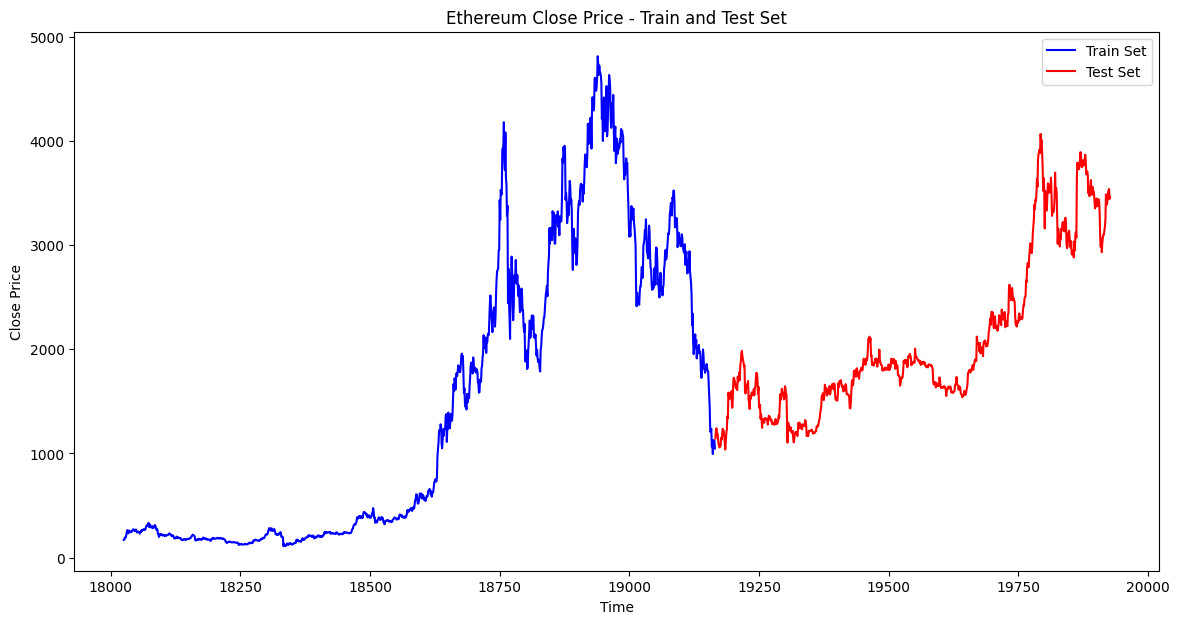

In [11]:
split_index = int(0.6 * len(eth_data))
train_data = eth_data[:split_index]
test_data = eth_data[split_index:]

plt.figure(figsize=(14, 7))

plt.plot(train_data['Time'], train_data['Close'], label='Train Set', color='blue')

plt.plot(test_data['Time'], test_data['Close'], label='Test Set', color='red')

plt.title('Ethereum Close Price - Train and Test Set')
plt.xlabel('Time')
plt.ylabel('Close Price')
plt.legend()
plt.show()

In [12]:
print(eth_data.isnull().sum())

Time           0
Open           0
High           0
Low            0
Close          0
Vol            0
Change         0
EMA_7          0
EMA_25         0
EMA_99         0
upper_band     0
middle_band    0
lower_band     0
RSI            0
slowk          0
slowd          0
MACD           0
MACD_signal    0
MACD_hist      0
CCI            0
ATR            0
ROC            0
BP             0
TR             0
UO             0
dtype: int64


# Construct Environment

In [57]:
import gym
from gym import spaces
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

MAX_BALANCE = 2147000000
MAX_NET_WORTH = 2147000000
MAX_HOLDINGS = 2147000000

class CryptoTradingEnv(gym.Env):
    metadata = {'render.modes': ['human']}
    MAX_BALANCE = 2147000000
    MAX_NET_WORTH = 2147000000
    MAX_HOLDINGS = 2147000000

    def __init__(self, df, window_size=40, initial_balance=3000):
        super(CryptoTradingEnv, self).__init__()
        self.df_original = df.reset_index(drop=True)
        self.df = self._normalize(df)
        self.window_size = window_size
        self.initial_balance = initial_balance
        self.transaction_fee_percent = 0.01 / 100
        self.min_trade_unit = 0.01
        self.initial_holding_price = 0
        self.action_space = spaces.Box(low=np.array([0, 0]), high=np.array([2, 1]), dtype=np.float32)
        num_features = self.df.shape[1] + 4
        self.observation_space = spaces.Box(low=-np.inf, high=np.inf, shape=(self.window_size, num_features), dtype=np.float32)
        self.net_worth_change_history = []
        self.open_positions = []
        self.close_positions = []
        self.cumulative_returns = 1 


        self.reset()

    def _normalize(self, df):
        df_normalized = df.copy()
        columns_to_normalize = ['Open', 'High', 'Low', 'Close', 'Vol', 'Change','EMA_7', 'EMA_25', 'EMA_99',
                                'upper_band', 'middle_band', 'lower_band', 'RSI', 'slowk', 'slowd', 'MACD', 
                                'MACD_signal', 'MACD_hist', 'CCI', 'ATR', 'ROC', 'BP', 'TR', 'UO']
        for column in columns_to_normalize:
            max_value = df[column].max()
            min_value = df[column].min()
            if max_value > min_value:
                df_normalized[column] = (df[column] - min_value) / (max_value - min_value)
            else:
                df_normalized[column] = df[column]
        return df_normalized

    def _next_observation(self):
        market_obs = self.df.iloc[self.current_step:self.current_step + self.window_size].values
        extra_obs = np.array([
            [self.balance / MAX_BALANCE,
             self.holdings / MAX_HOLDINGS,
             self.net_worth / MAX_NET_WORTH,
             self.transaction_fee_percent]
        ])
        if market_obs.ndim > 1:
            extra_obs_repeated = np.repeat(extra_obs, market_obs.shape[0], axis=0)
        else:
            extra_obs_repeated = extra_obs
        full_obs = np.concatenate((market_obs, extra_obs_repeated), axis=1)
        return full_obs

    def _take_action(self, action):
        current_price = self.df_original.loc[self.current_step, "Close"]
        action_type = action[0]
        action_percentage = action[1]
        net_worth_change = self.net_worth - self.previous_net_worth
        self.net_worth_change_history.append(net_worth_change)
        self.previous_net_worth = self.net_worth
    
        # Calculate the percentage change if holdings exist
        price_change = ((current_price - self.initial_holding_price) / self.initial_holding_price) if hasattr(self, 'initial_holding_price') else 0
    
        if action_type < 2 / 3:
            buy_amount = self.balance * action_percentage
            if buy_amount > 0:
                shares_bought = buy_amount / current_price
                self.balance -= shares_bought * current_price * (1 + self.transaction_fee_percent)
                self.holdings += shares_bought
                self.initial_holding_price = current_price  # Set the buying price
                self.open_positions.append((self.current_step, current_price))
                self.initial_holding_price = current_price
        elif 2 / 3 <= action_type < 4 / 3:
            # Holding, do nothing
            pass
        else:
            # Check for stop-loss or take-profit conditions
            if price_change <= -0.5 or price_change >= 1:
                # Force sell all holdings if stop-loss or take-profit conditions are met
                shares_sold = self.holdings
                self.close_positions.append((self.current_step, current_price))
            else:
                shares_sold = min(self.holdings, self.holdings * action_percentage)
            
            self.balance += shares_sold * current_price * (1 - self.transaction_fee_percent)
            self.holdings -= shares_sold
    
        self.balance = min(self.balance, self.MAX_BALANCE)
        self.net_worth = self.balance + self.holdings * current_price
        self.net_worth = min(self.net_worth, self.MAX_NET_WORTH)
        self.net_worth_history.append(self.net_worth)


    def step(self, action):
        self._take_action(action)
        self.current_step += 1

        if len(self.net_worth_history) > 1:
            returns = np.diff(self.net_worth_history) / self.net_worth_history[:-1]                        
            cumulative_returns = np.prod(1 + returns) - 1                                                  
            average_return = np.mean(returns) * self.current_step if len(returns) > 0 else 0               
            volatility = np.std(returns) * np.sqrt(self.current_step) if len(returns) > 1 else 0           
            sharpe_ratio = average_return / volatility if volatility != 0 else 0                           
        else:
            cumulative_return, average_return, volatility, sharpe_ratio = 0, 0, 0, 0
    
        # Risk-adjusted metrics
        var = self.calculate_var()
        es = self.calculate_es()
        max_drawdown = self.calculate_max_drawdown()
        sortino_ratio = self.calculate_sortino_ratio()        
        # Calculate total return percent
        total_return_percent = (self.net_worth - self.initial_balance) / self.initial_balance * 100
    
        # Loss aversion - more penalty on losses
        loss_aversion_multiplier = 1
        adjusted_return = average_return if average_return > 0 else average_return * loss_aversion_multiplier

        # Define a target return and adjust reward towards stabilizing around this target
        target_return =  500 # target return percentage
        return_difference = abs(total_return_percent - target_return) if total_return_percent != target_return else 1

    
        # Reward calculation incorporating Sortino ratio and loss aversion
        reward = (adjusted_return + sortino_ratio + sharpe_ratio + cumulative_returns) / return_difference

        # Check if end condition met
        done = self.current_step >= len(self.df) - self.window_size
    
        obs = self._next_observation()
        return obs, reward, done, {}

    def calculate_sortino_ratio(self, target=0):
        returns = np.array(self.net_worth_history[1:]) / np.array(self.net_worth_history[:-1]) - 1
        downside_returns = returns[returns < target]
        expected_return = np.mean(returns)
        downside_deviation = np.sqrt(np.mean(np.square(downside_returns - target))) if len(downside_returns) > 0 else 0
        sortino_ratio = expected_return / downside_deviation if downside_deviation > 0 else 0
        return sortino_ratio


    def calculate_var(self, percentile=5):
        if len(self.net_worth_history) < 2:
            return 0
        net_worth_changes = np.diff(self.net_worth_history)
        var = np.percentile(net_worth_changes, percentile)
        return var

    def calculate_es(self, percentile=5):
        if len(self.net_worth_history) < 2:
            return 0
        net_worth_changes = np.diff(self.net_worth_history)
        var = self.calculate_var(percentile)
        losses_below_var = net_worth_changes[net_worth_changes <= var]
        return np.mean(losses_below_var) if len(losses_below_var) > 0 else 0


    def calculate_max_drawdown(self):
        if not self.net_worth_history:
            return 0
        max_drawdown = 0
        peak = self.net_worth_history[0]
        for net_worth in self.net_worth_history:
            if net_worth > peak:
                peak = net_worth
            drawdown = (peak - net_worth) / peak
            if drawdown > max_drawdown:
                max_drawdown = drawdown
        return max_drawdown

    def reset(self):
        self.balance = self.initial_balance
        self.holdings = 0
        self.net_worth = self.initial_balance
        self.net_worth_history = [self.initial_balance]
        self.initial_holding_price = 0  # Reset the buying price
        self.previous_net_worth = self.initial_balance  # Initialize the previous_net_worth here
        self.current_step = 0
        return self._next_observation()

    def render(self, mode='human', close=False):
        if close:
            return
        plt.figure(figsize=(15, 5))
        plt.plot(self.net_worth_history)
        plt.title('Net Worth Over Time')
        plt.ylabel('Net Worth')
        plt.xlabel('Step')
        plt.show()

In [51]:
# Instantiate the environment CryptoTradingEnv and extract key parameter information from it
env = CryptoTradingEnv(eth_data)

# Get environment parameter information
state_dim = env.observation_space.shape
action_dim = env.action_space.shape

# For Box space, the maximum action value is no longer a single value, but the upper bound of each dimension
max_action = env.action_space.high

# Get the maximum number of steps in the dataset, suitable for environment
max_step = len(eth_data) - env.window_size

print(f'State dimensions: {state_dim}, Action dimensions: {action_dim}, Max action value: {max_action}, Max step: {max_step}')


State dimensions: (40, 29), Action dimensions: (2,), Max action value: [2. 1.], Max step: 1863


# Construct Agent

In [52]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np

class StockAgent:
    def __init__(self, algorithm):
        self.algorithm = algorithm
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

    def predict(self, obs):
        try:
            obs = torch.tensor(obs.reshape(1, -1), dtype=torch.float32, device=self.device)
            with torch.no_grad():
                action = self.algorithm.predict(obs)
            action_numpy = action.cpu().numpy()[0]
            return action_numpy
        except Exception as e:
            print(f"An error occurred during prediction: {e}")
            # Return a default action or error handling logic
            return np.zeros(action.shape)  # Assume that an all-zero action array is returned here

    def sample(self, obs):
        try:
            obs = torch.tensor(obs.reshape(1, -1), dtype=torch.float32, device=self.device)
            with torch.no_grad():
                action = self.algorithm.sample(obs)
            action_numpy = action.cpu().numpy()[0]
            return action_numpy
        except Exception as e:
            print(f"An error occurred during sampling: {e}")
            return np.zeros(action.shape)

    def learn(self, obs, action, reward, next_obs, terminal):
        try:
            terminal = np.expand_dims(terminal, axis=-1)
            reward = np.expand_dims(reward, axis=-1)

            obs = torch.tensor(obs, dtype=torch.float32, device=self.device)
            action = torch.tensor(action, dtype=torch.float32, device=self.device)
            reward = torch.tensor(reward, dtype=torch.float32, device=self.device)
            next_obs = torch.tensor(next_obs, dtype=torch.float32, device=self.device)
            terminal = torch.tensor(terminal, dtype=torch.float32, device=self.device)

            critic_loss, actor_loss = self.algorithm.learn(obs, action, reward, next_obs, terminal)
            return critic_loss.item(), actor_loss.item()
        except Exception as e:
            print(f"An error occurred during learning: {e}")
            return 0.0, 0.0

In [53]:
import torch
import torch.nn as nn
import torch.nn.functional as F

LOG_SIG_MAX = 1.0
LOG_SIG_MIN = -20

class StockModel(nn.Module):
    def __init__(self, obs_dim, action_dim):
        super(StockModel, self).__init__()
        self.actor_model = Actor(obs_dim, action_dim)
        self.critic_model = Critic(obs_dim, action_dim)

    def policy(self, obs):
        return self.actor_model(obs)

    def value(self, obs, action):
        return self.critic_model(obs, action)

    def get_actor_params(self):
        return self.actor_model.parameters()

    def get_critic_params(self):
        return self.critic_model.parameters()

class Critic(nn.Module):
    def __init__(self, obs_dim, action_dim):
        super(Critic, self).__init__()
        flat_obs_dim = np.prod(obs_dim)
        self.l1 = nn.Linear(flat_obs_dim + action_dim, 256)
        self.l2 = nn.Linear(256, 256)
        self.l3 = nn.Linear(256, 1)

        self.l4 = nn.Linear(flat_obs_dim + action_dim, 256)
        self.l5 = nn.Linear(256, 256)
        self.l6 = nn.Linear(256, 1)

        self.apply(self.init_weights)

    def forward(self, obs):
        obs = obs.view(obs.size(0), -1)
        x = F.leaky_relu(self.l1(obs), 0.01)  # Using LeakyReLU for a bit more robustness
        x = F.leaky_relu(self.l2(x), 0.01)
        
        act_mean = self.mean_linear(x)
        act_std = self.std_linear(x)
        act_log_std = torch.clamp(act_std, min=LOG_SIG_MIN, max=LOG_SIG_MAX)
        return act_mean, act_log_std

    @staticmethod
    def init_weights(m):
        if type(m) == nn.Linear:
            nn.init.xavier_uniform_(m.weight)
            nn.init.constant_(m.bias, 0)

In [54]:
SEED = 0 # Random seed, used to ensure the repeatability of the experiment
EVAL_EPISODES = 5 # Number of evaluation rounds, that is, how many complete environment episodes are run during the evaluation
# The MEMORY_SIZE parameter is not necessary for PPO, because PPO learns directly from recent experience and does not rely on a large experience replay pool
BATCH_SIZE = 64 # Batch size, the number of samples used by the PPO algorithm when processing data for each epoch
GAMMA = 0.995 # Discount factor, used to calculate the current value of future rewards, important for all reinforcement learning algorithms
ACTOR_LR = 1e-4 # Learning rate of the actor network
CRITIC_LR = 1e-4 # Learning rate of the critic network, usually called the learning rate of the value function in PPO
CLIP_PARAM = 0.2 # Clipping parameter, limiting the amplitude of policy updates, which is an important parameter unique to PPO
MAX_REWARD = -1e9 # Maximum reward, used to initialize or compare the optimal reward value, used to track the best performance during training
file_name = 'ppo_Crypto' # The name of the model saved, reflecting the algorithm and application field

In [55]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import numpy as np

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

class Actor(nn.Module):
    def __init__(self, state_dim, action_dim):
        super(Actor, self).__init__()
        self.l1 = nn.Linear(np.prod(state_dim), 64)
        self.l2 = nn.Linear(64, 64)
        self.mean = nn.Linear(64, action_dim)
        self.log_std = nn.Linear(64, action_dim)
        self.apply(self.init_weights)
        self.total_step_count = 0  # Initialize the step counter

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, mean=0., std=0.1)
            nn.init.constant_(m.bias, 0)

    def forward(self, state):
        state = torch.flatten(state, start_dim=1)  # Flatten the state
        x = F.relu(self.l1(state))
        x = F.relu(self.l2(x))
        # For the action type, we use the tanh function to get the output value between [-1, 1]
        action_type = torch.tanh(self.mean(x))
        action_percentage = torch.sigmoid(self.log_std(x))
        # Return the action type and action percentage
        return action_type, action_percentage
        
class Critic(nn.Module):
    def __init__(self, state_dim):
        super(Critic, self).__init__()
        self.l1 = nn.Linear(np.prod(state_dim), 64)
        self.l2 = nn.Linear(64, 64)
        self.l3 = nn.Linear(64, 1)
        self.apply(self.init_weights)

    def init_weights(self, m):
        if isinstance(m, nn.Linear):
            nn.init.normal_(m.weight, mean=0., std=0.1)
            nn.init.constant_(m.bias, 0)

    def forward(self, state):
        state = torch.flatten(state, start_dim=1)  # Flatten the state
        x = F.relu(self.l1(state))
        x = F.relu(self.l2(x))
        return self.l3(x)

class PPO(nn.Module):
    def __init__(self, state_dim, action_dim, lr_actor, lr_critic, gamma, K_epochs, eps_clip):
        super(PPO, self).__init__()
        self.gamma = gamma
        self.eps_clip = eps_clip
        self.K_epochs = K_epochs
        self.actor = Actor(state_dim, action_dim).to(device)
        self.critic = Critic(state_dim).to(device)
        self.optimizer_actor = optim.Adam(self.actor.parameters(), lr=lr_actor)
        self.optimizer_critic = optim.Adam(self.critic.parameters(), lr=lr_critic)
        self.MseLoss = nn.MSELoss()
        self.device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
        self.actor = Actor(state_dim, action_dim).to(self.device)
        self.critic = Critic(state_dim).to(self.device)

    def load_weights(self, file_name):
        if os.path.isfile(file_name):
            print("Loading model weights...")
            self.load_state_dict(torch.load(file_name, map_location=self.device))
        else:
            print("Model file not found, training from scratch.")

    def select_action(self, state, memory):
        state_tensor = torch.FloatTensor(state).reshape(1, -1).to(device)
        mean, log_std = self.actor(state_tensor)
        std = torch.exp(log_std)
        dist = torch.distributions.Normal(mean, std)
        sampled_actions = dist.sample()

        # Add random exploration to encourage the model to try different actions
        epsilon = 0.1  # Exploration rate, can be adjusted
        if random.random() < epsilon:
            # Randomly select an action type in the complete action space
            action_type = np.random.uniform(0, 2)
            # Randomly select an action percentage between (0, 1)
            action_percentage = np.random.uniform(0, 1)
        else:
            # Use the output of the tanh activation function to adjust the action type
            action_type = (torch.tanh(mean[0, 0]) + 1) * (2 / 3) # Adjust (-1, 1) to (0, 2)
            action_type = action_type.item()
            
            # The action percentage still uses the sigmoid activation function
            action_percentage = torch.sigmoid(mean[0, 1])
            action_percentage = action_percentage.item()
    
        final_action = [action_type, action_percentage]
    
        memory.states.append(state)
        memory.actions.append(final_action)
        memory.logprobs.append(dist.log_prob(sampled_actions).sum().detach().cpu().numpy())
    
        return final_action


    def update(self, memory):
        rewards = []
        discounted_reward = 0
        for reward, is_terminal in zip(reversed(memory.rewards), reversed(memory.is_terminals)):
            if is_terminal:
                discounted_reward = 0
            discounted_reward = reward + (self.gamma * discounted_reward)
            rewards.insert(0, discounted_reward)
        
        rewards = torch.tensor(np.array(memory.rewards), dtype=torch.float32, device=self.device)
        rewards = (rewards - rewards.mean()) / (rewards.std() + 1e-7)
        is_terminals = torch.tensor(np.array(memory.is_terminals), dtype=torch.float32, device=self.device)
    
        old_states = torch.stack([torch.tensor(s, dtype=torch.float32, device=self.device) for s in memory.states])
        old_actions = torch.stack([torch.tensor(a, dtype=torch.float32, device=self.device) for a in memory.actions])
        old_logprobs = torch.stack([torch.tensor(lp, dtype=torch.float32, device=self.device) for lp in memory.logprobs])
    
        for _ in range(self.K_epochs):
            logprobs, state_values, dist_entropy = self.evaluate(old_states, old_actions)

            old_logprobs = old_logprobs.view(logprobs.shape)
            
            ratios = torch.exp(logprobs - old_logprobs.detach())
            advantages = rewards - state_values.detach()
            surr1 = ratios * advantages
            surr2 = torch.clamp(ratios, 1-self.eps_clip, 1+self.eps_clip) * advantages
            loss = -torch.min(surr1, surr2) + 0.5*self.MseLoss(state_values, rewards) - 0.01*dist_entropy
    
            self.optimizer_actor.zero_grad()
            self.optimizer_critic.zero_grad()
            loss.mean().backward()
            self.optimizer_actor.step()
            self.optimizer_critic.step()
        
        memory.clear()

    def evaluate(self, state, action):
        mean, log_std = self.actor(state)
        std = log_std.exp()
        dist = torch.distributions.Normal(mean, std)
        action_logprobs = dist.log_prob(action).sum(axis=-1)
        dist_entropy = dist.entropy().sum(axis=-1)
        state_value = self.critic(state)
        
        return action_logprobs, state_value, dist_entropy


# Model Training and Visualization

Do you want to load the optimal weights? If yes, please enter 1, if not, please enter 0:  0


Weights not loaded, using initial model parameters.
Episode 0, Final Net Worth: 14901.08602547395, Return: 396.70%, Return Volatility: 0.050067, Total Rewards: 120.24
Episode 100, Final Net Worth: 25783.732595179532, Return: 759.46%, Return Volatility: 0.049775, Total Rewards: 26.15
Episode 200, Final Net Worth: 27470.217679130175, Return: 815.67%, Return Volatility: 0.049868, Total Rewards: 23.42
Episode 300, Final Net Worth: 18766.276441386697, Return: 525.54%, Return Volatility: 0.049283, Total Rewards: 46.75
Episode 400, Final Net Worth: 19572.06678748625, Return: 552.40%, Return Volatility: 0.048676, Total Rewards: 32.42
Episode 500, Final Net Worth: 23109.918962542604, Return: 670.33%, Return Volatility: 0.050067, Total Rewards: 30.66
Episode 600, Final Net Worth: 25772.020456614297, Return: 759.07%, Return Volatility: 0.049700, Total Rewards: 25.29
Episode 700, Final Net Worth: 20494.953831181585, Return: 583.17%, Return Volatility: 0.050145, Total Rewards: 31.30
Episode 800, Fi

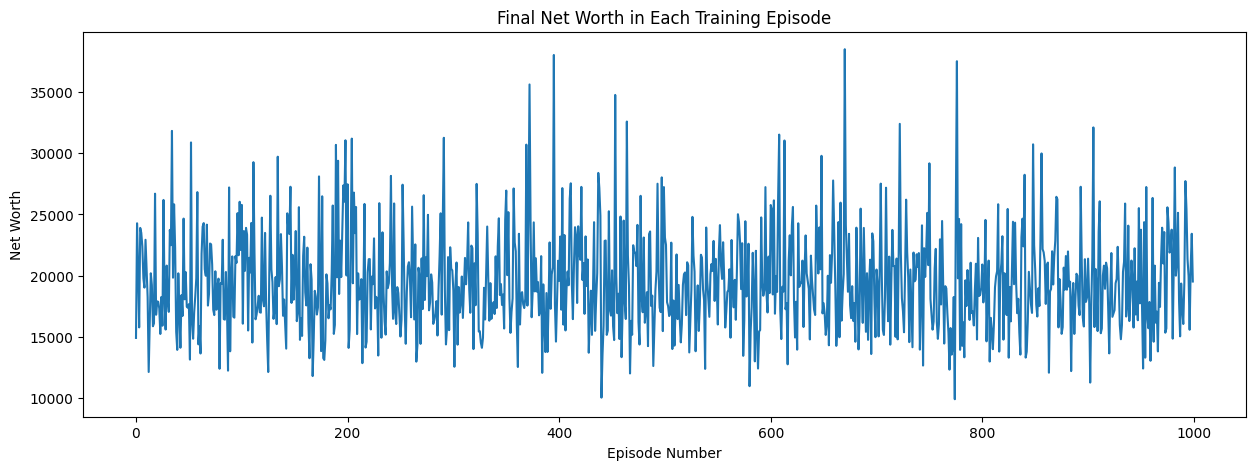

Training completed
Test 0, Final Net Worth: 8563.716324349403, Return: 185.46%, Return Volatility: 0.648547, Total Rewards: 4.80
Test 100, Final Net Worth: 7958.238743662028, Return: 165.27%, Return Volatility: 0.659363, Total Rewards: 4.44
Test 200, Final Net Worth: 8849.554819945946, Return: 194.99%, Return Volatility: 0.654210, Total Rewards: 5.31
Average Test Return: 182.41%
Average Test Volatility: 0.66
Re_Vola Ratio: 2.75


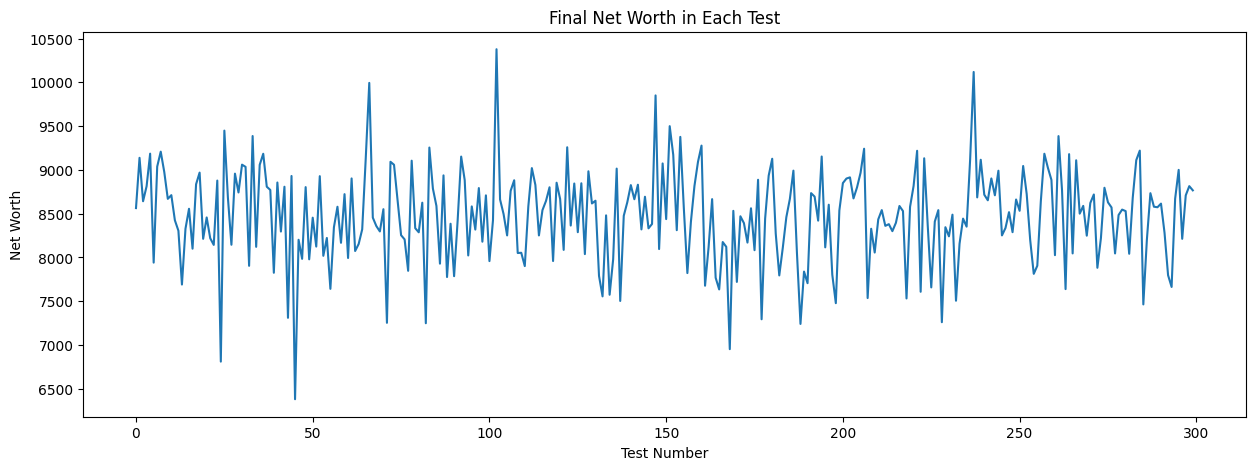

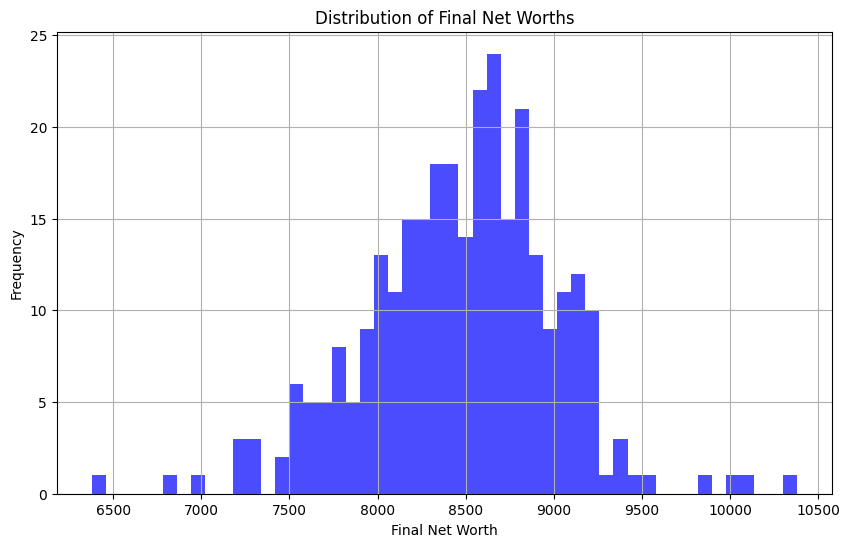

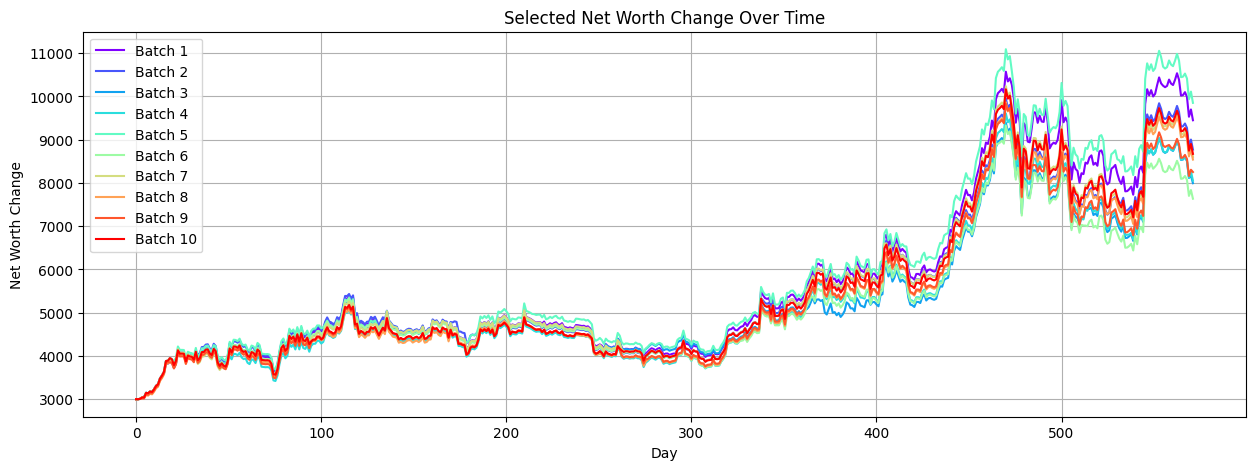

In [58]:
### import gym
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
warnings.filterwarnings("ignore")

class Memory:
    def __init__(self):
        self.actions = []
        self.states = []
        self.logprobs = []
        self.rewards = []
        self.is_terminals = []

    def clear(self):
        del self.actions[:]
        del self.states[:]
        del self.logprobs[:]
        del self.rewards[:]
        del self.is_terminals[:]

# Divide the dataset into training and test sets
split_index = int(0.7 * len(eth_data))
train_data = eth_data[:split_index]
test_data = eth_data[split_index:]

# Initialize the environment
env = CryptoTradingEnv(df=train_data)  # Using training data
state_dim = np.prod(env.observation_space.shape)
action_dim = env.action_space.shape[0]

# Initialize PPO agent
memory = Memory()
ppo_agent = PPO(state_dim, action_dim, lr_actor=1e-4, lr_critic=1e-4, gamma=0.995, K_epochs=4, eps_clip=0.2)

# Ask the user whether to load the optimal weights
load_weights = input("Do you want to load the optimal weights? If yes, please enter 1, if not, please enter 0: ")
if load_weights == "1":
    weights_path = 'best_model.pth'
    ppo_agent.load_weights(weights_path)
    print("Weight loaded successfully!")
    print(f"The Re_Vola_Ratio of the loaded model is: {best_ratio:.2f}")
else:
    print("Weights not loaded, using initial model parameters.")

# Training loop
num_episodes = 1000 # Total training episodes
total_rewards = 0 # Initialize the total reward variable
net_worth_over_episodes = [] # Used to record the net value of each episode

for episode in range(num_episodes):
    state = env.reset()
    episode_net_worths = [env.initial_balance] # Record the net value after each step
    episode_returns = [] # Store the return rate of each step
    episode_rewards = 0 # Rewards for this round

    while True:
        action = ppo_agent.select_action(state, memory)
        next_state, reward, done, _ = env.step(action)
        episode_net_worths.append(env.net_worth) # Update the net value after each step
        state = next_state
        episode_rewards += reward # Accumulate the rewards for this round
        memory.rewards.append(reward)

        if len(episode_net_worths) > 1:
            # Calculate the return rate between the latest two steps
            recent_return = (episode_net_worths[-1] - episode_net_worths[-2]) / episode_net_worths[-2]
            episode_returns.append(recent_return)  # Add to the return rate list

        if done:
            # If episode_returns has at least 2 values, calculate volatility
            if len(episode_returns) > 1:
                return_volatility = np.std(episode_returns)
            else:
                return_volatility = 0  # If there is only one step, the volatility is 0

            net_worth_over_episodes.append(env.net_worth)  # Record net value
            if episode % 100 == 0:
                return_percentage = (env.net_worth - env.initial_balance) / env.initial_balance
                print(f'Episode {episode}, Final Net Worth: {env.net_worth}, Return: {return_percentage:.2%}, Return Volatility: {return_volatility:.6f}, Total Rewards: {episode_rewards:.2f}')
            break

    total_rewards += episode_rewards  # Accumulate rewards during the entire training process
    ppo_agent.update(memory)
    memory.clear()

# Draw the net value change graph of the training set
plt.figure(figsize=(15, 5))
plt.plot(net_worth_over_episodes)
plt.title('Final Net Worth in Each Training Episode')
plt.ylabel('Net Worth')
plt.xlabel('Episode Number')
plt.show()

print('Training completed')

# Testing loop
test_env = CryptoTradingEnv(df=test_data) # Using test data
test_final_net_worths = []
test_returns = [] # Store returns for each test
test_volatilities = [] # Store volatility for each test
# Initialize list for plotting
test_net_worth_during_tests = []
num_tests = 300

initial_balance = 3000 # Beginning balance
best_ratio = float('-inf') # Initialize best performance ratio

for test in range(num_tests):
    test_state = test_env.reset()
    test_net_worths = [test_env.initial_balance] # Initialize the net worth list for the test, including the initial balance first
    test_daily_returns = [] # Store daily returns
    test_rewards = [] # Store rewards for each step in a single test
    total_test_rewards = 0 # Accumulate the total rewards for this test

    while True:
        test_action = ppo_agent.select_action(test_state, memory)
        test_state, test_reward, test_done, _ = test_env.step(test_action)
        test_net_worths.append(test_env.net_worth)  # Update test net value
        total_test_rewards += test_reward  # Accumulated rewards
        test_rewards.append(test_reward)

        if len(test_net_worths) > 1:
            # Calculate the return rate between the latest two steps
            recent_return = (test_net_worths[-1] - test_net_worths[-2]) / test_net_worths[-2]
            test_daily_returns.append(recent_return)  # Add to the return rate list

        if test_done:
            final_net_worth = test_env.net_worth
            test_final_net_worths.append(final_net_worth)
            test_return = (final_net_worth - initial_balance) / initial_balance

            # If test_daily_returns has at least 2 values, calculate volatility
            if len(test_daily_returns) > 1:
                test_return_volatility = np.std(test_daily_returns) * len(test_data) ** 0.5
            else:
                test_return_volatility = 0  # If there is only one step, the volatility is 0

            test_returns.append(test_return)
            test_volatilities.append(test_return_volatility)

            if test % 100 == 0:
                print(f'Test {test}, Final Net Worth: {final_net_worth}, Return: {test_return:.2%}, Return Volatility: {test_return_volatility:.6f}, Total Rewards: {total_test_rewards:.2f}')
            break
    # After the test is finished, add the net value data of the entire test to the external list
    test_net_worth_during_tests.append(test_net_worths)

# Print test average return rate and volatility
print(f'Average Test Return: {np.mean(test_returns):.2%}')
print(f'Average Test Volatility: {np.mean(test_return_volatility):.2f}')
print(f'Re_Vola Ratio: {np.mean(test_returns)/np.mean(test_return_volatility):.2f}')

plt.figure(figsize=(15, 5))
plt.plot(test_final_net_worths)
plt.title('Final Net Worth in Each Test')
plt.ylabel('Net Worth')
plt.xlabel('Test Number')
plt.show()

plt.figure(figsize=(10, 6))
plt.hist(test_final_net_worths, bins=50, color='blue', alpha=0.7)
plt.title('Distribution of Final Net Worths')
plt.xlabel('Final Net Worth')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

#### Drawing
num_lines_to_draw = 10
num_tests = len(test_net_worth_during_tests) # Total number of tests
test_group_size = num_tests // num_lines_to_draw # Size of each batch of tests
# Actual number of days in the test set
test_days = len(test_data.index)

# Choose a color for each line
colors = cm.rainbow(np.linspace(0, 1, num_lines_to_draw))

plt.figure(figsize=(15, 5))

# Randomly select a test from each group to draw
for i in range(num_lines_to_draw):
    # Calculate the starting index of each batch
    start_idx = i * test_group_size
    # Select the test index to plot
    selected_test_idx = np.random.choice(range(start_idx, start_idx + test_group_size))
    selected_net_worths = test_net_worth_during_tests[selected_test_idx]
    # Create a time series
    times = np.linspace(0, test_days, len(selected_net_worths))
    plt.plot(times, selected_net_worths, color=colors[i], label=f'Batch {i+1}')

plt.title('Selected Net Worth Change Over Time')
plt.xlabel('Day')
plt.ylabel('Net Worth Change')
plt.legend()
plt.grid(True)
plt.show()

## Trading Bot Result Compare to Directly Holding ETH

In [63]:
# Assumed initial account balance
initial_balance = 3000

# Used to store the net value change percentage for each test
net_worth_changes_percent = []

# Calculate the net value change percentage for each test
for final_net_worth in test_final_net_worths:
    percent_change = ((final_net_worth - initial_balance) / initial_balance)
    net_worth_changes_percent.append(percent_change)

# Calculate average return and volatility
average_return = np.mean(net_worth_changes_percent)
volatility = np.std(net_worth_changes_percent)
Re_Vola_ratio = average_return / volatility
cumulative_return = np.prod([(1 + change/100) for change in net_worth_changes_percent]) - 1

print(f"Cumulative Return: {cumulative_return:.4f}")
print(f"Average Return: {average_return:.4f}")
print(f"Volatility: {volatility:.4f}")
print(f"Re_Vola_ratio: {Re_Vola_ratio:.4f}")

Cumulative Return: 225.4716
Average Return: 1.8241
Volatility: 0.1787
Re_Vola_ratio: 10.2068


In [64]:
# Calculate daily return, which is the ratio of today's price to yesterday's price minus 1
daily_returns = test_data['Close'].pct_change()

# Drop NaN values ​​(there will be a NaN since the first day has no data from the previous day)
daily_returns = daily_returns.dropna()

# Calculate cumulative return using cumprod, then subtract 1 to get the cumulative return percentage
cumulative_returns = (1 + daily_returns).cumprod() - 1

# Calculate volatility, which is the standard deviation of daily returns
volatility = daily_returns.std() * len(test_data) ** 0.5

mean_returns = daily_returns.mean() * len(test_data)

ShR = maen_returns / volatility

# Print results
print("Cumlative Return:", cumulative_returns.iloc[-1]) # Take the last value as the cumulative return for the entire period
print("mean returns:", mean_returns)
print("Volatility:", volatility)
print("Re_Vola_ratio:", ShR)

Cumlative Return: 1.896276150627605
mean returns: 1.282006824422182
Volatility: 0.6620474596575078
Re_Vola_ratio: 5.53723567363989
